In [1]:
from fastai.vision import *
from fastai.vision.gan import *

In [2]:
from src.config import *
from src.models.wgan import *

### Look at training data

In [3]:
training_data = pd.read_csv(path_trainingset)

In [4]:
training_data.head()

,Image,Mask,is_validation
0,ISIC_0000031.jpg,ISIC_0000031_segmentation.png,True
1,ISIC_0010204.jpg,ISIC_0010204_segmentation.png,True
2,ISIC_0013089.jpg,ISIC_0013089_segmentation.png,True
3,ISIC_0014522.jpg,ISIC_0014522_segmentation.png,False
4,ISIC_0013767.jpg,ISIC_0013767_segmentation.png,False


## Generate masks

#### Create databunch

In [5]:
data = (GANItemList.from_df(path=path_mask, df=training_data.drop(['Image', 'is_validation'], axis = 1), noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=None, size=128, tfm_y=True)
               .databunch(bs=128)
               .normalize(stats = [torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])], do_x=False, do_y=True))

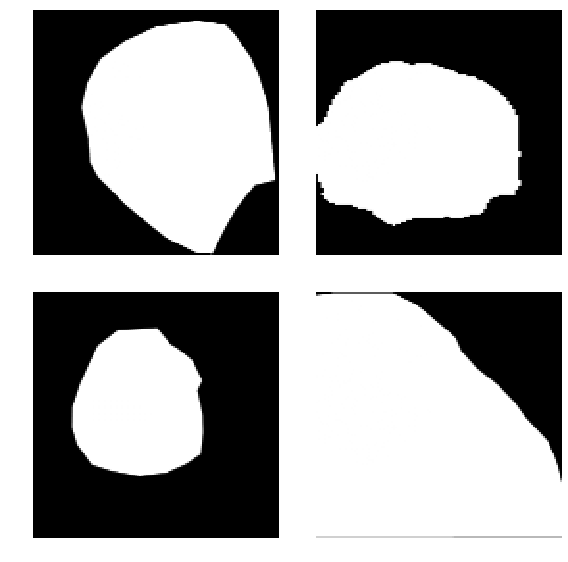

In [6]:
data.show_batch(rows=2)

#### Create the GAN model

In [15]:
generator = basic_generator(in_size=img_size, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=img_size, n_channels=3, n_extra_layers=1)

In [16]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                    opt_func = partial(optim.Adam, betas = (0., 0.99)), wd=0., model_dir=Path('models/'))

#### Train the GAN model

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.010960,#na#,0.067094,-0.022810,01:55
1,-0.033303,#na#,0.086340,-0.056134,02:01
2,-0.058800,#na#,0.107731,-0.091786,01:57
3,-0.079605,#na#,0.107539,-0.111267,02:00
4,-0.083634,#na#,0.068055,-0.107865,01:56
5,-0.076389,#na#,0.070068,-0.103029,01:54
6,-0.081991,#na#,0.042551,-0.098584,01:57
7,-0.102403,#na#,-0.010296,-0.105828,02:00
8,-0.109401,#na#,0.010458,-0.126757,01:55
9,-0.110768,#na#,0.002431,-0.125592,01:56


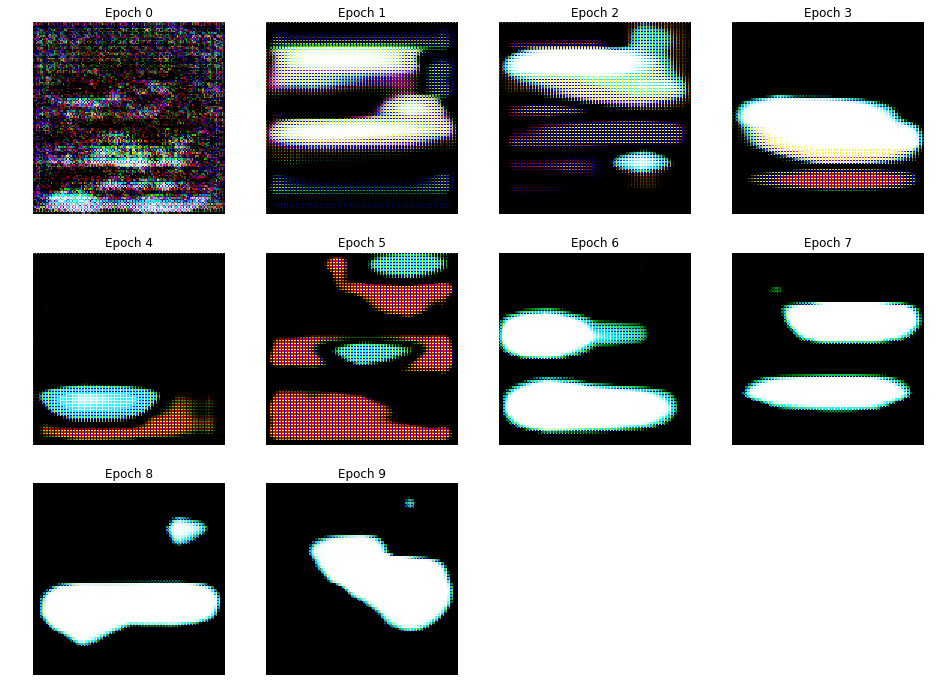

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f4abe77bea0>
Traceback (most recent call last):
  File "/home/sondre/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/sondre/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/sondre/anaconda3/envs/fastai/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f4abe77bea0>
Traceback (most recent call last):
  File "/home/sondre/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/sondre/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader

In [17]:
learn.fit(10 ,2e-2)

Save model

In [18]:
torch.save(generator, path_models + '/wgan_generator.pth')
torch.save(critic.state_dict(), path_models + '/wgan_critic.pth')

Load model

In [13]:
generator = torch.load(path_models + '/wgan_generator.pth')
critic.load_state_dict(torch.load(path_models + '/wgan_critic.pth'))
critic.to("cuda")

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4),

#### Save predictions

In [20]:
save_pred(generator, path_gen + '/generated_masks', 1000)

#### Clean images

In [21]:
image_cleaner(path_gen + '/generated_masks')